In [9]:
from pathlib import Path
import sys
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.append(str(ROOT))

print("ROOT:", ROOT)
print("sys.path contains ROOT:", str(ROOT) in sys.path)

from src.modeling import (
    train_val_test_split,
    scale_numeric,
    train_logistic_regression,
    train_random_forest,
    train_gradient_boosting,
    evaluate_classifier,
)
from src.visualization import plot_confusion_matrix, plot_roc_curve


from src.risk_bands import (
    compute_pd,
    assign_risk_band,
    build_portfolio_df,
    summarize_by_band,
)

df_loans_fe = pd.read_csv(ROOT / "data/processed/loan_default_features.csv")
df_credit_fe = pd.read_csv(ROOT / "data/processed/credit_risk_features.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ROOT: /Users/erincheng/Desktop/credit-risk-analysis
sys.path contains ROOT: True


In [10]:
datasets = {
    "loan_default": {
        "df": df_loans_fe,
        "target": "default",
        "numeric_cols": [
            "age", "income", "loan_amount", "credit_score",
            "months_employed", "num_credit_lines",
            "interest_rate", "loan_term", "dti_ratio",
        ],
    },
    "credit_risk": {
        "df": df_credit_fe,
        "target": "default_flag",
        "numeric_cols": [
            "person_age", "person_income", "person_emp_length",
            "loan_amnt", "loan_int_rate", "loan_percent_income",
            "cb_person_cred_hist_length",
        ],
    },
}


In [3]:
all_results = {}

for name, cfg in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    df = cfg["df"].copy()
    target = cfg["target"]
    numeric_cols = cfg["numeric_cols"]

    # Split
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
        df, target=target
    )

    # Keep only numeric columns for all models
    X_train_num = X_train.select_dtypes(include=["number"])
    X_val_num   = X_val.select_dtypes(include=["number"])
    X_test_num  = X_test.select_dtypes(include=["number"])

    # Scale numeric for linear model
    X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_numeric(
        X_train_num, X_val_num, X_test_num, numeric_cols
    )

    # Train models
    log_reg = train_logistic_regression(X_train_scaled, y_train)
    rf = train_random_forest(X_train_num, y_train)
    gb = train_gradient_boosting(X_train_num, y_train)

    # Define models *inside* the loop so they use the per-dataset data
    models = {
        "log_reg":           (log_reg, X_val_scaled, X_test_scaled),
        "random_forest":     (rf,      X_val_num,    X_test_num),
        "gradient_boosting": (gb,      X_val_num,    X_test_num),
    }

    dataset_results = {}

    for m_name, (model, Xv, Xt) in models.items():
        val_metrics = evaluate_classifier(model, Xv, y_val)
        test_metrics = evaluate_classifier(model, Xt, y_test)
        dataset_results[m_name] = {"val": val_metrics, "test": test_metrics}
        print(f"\nModel: {m_name}")
        print("  Val:", val_metrics)
        print("  Test:", test_metrics)

    all_results[name] = {
        "results": dataset_results,
        "splits": (X_train, X_val, X_test, y_train, y_val, y_test),
        "scaled": (X_train_scaled, X_val_scaled, X_test_scaled),
        "models": {
            "log_reg": log_reg,
            "random_forest": rf,
            "gradient_boosting": gb,
        },
    }

# Loan_default models
loan_log_reg = all_results["loan_default"]["models"]["log_reg"]
loan_rf      = all_results["loan_default"]["models"]["random_forest"]
loan_gb      = all_results["loan_default"]["models"]["gradient_boosting"]

# Credit_risk models
credit_log_reg = all_results["credit_risk"]["models"]["log_reg"]
credit_rf      = all_results["credit_risk"]["models"]["random_forest"]
credit_gb      = all_results["credit_risk"]["models"]["gradient_boosting"]



=== Dataset: loan_default ===

Model: log_reg
  Val: {'accuracy': 0.6751064725979314, 'precision': 0.21640843281686564, 'recall': 0.6882067851373183, 'f1': 0.3292753623188406, 'roc_auc': 0.7398275362382049}
  Test: {'accuracy': 0.6725792109327468, 'precision': 0.21334348046676813, 'recall': 0.6793214862681745, 'f1': 0.3247104247104247, 'roc_auc': 0.7441288468177572}

Model: random_forest
  Val: {'accuracy': 0.8851031965179951, 'precision': 0.6105263157894737, 'recall': 0.023424878836833602, 'f1': 0.045118630882924934, 'roc_auc': 0.7272317236310784}
  Test: {'accuracy': 0.8846351850985164, 'precision': 0.5578947368421052, 'recall': 0.021405492730210016, 'f1': 0.041229093737845196, 'roc_auc': 0.7326644078105078}

Model: gradient_boosting
  Val: {'accuracy': 0.8854776056535779, 'precision': 0.5606694560669456, 'recall': 0.05411954765751212, 'f1': 0.0987108655616943, 'roc_auc': 0.7445038833016107}
  Test: {'accuracy': 0.885805213647213, 'precision': 0.5714285714285714, 'recall': 0.0581583


=== Plots for loan_default – Gradient Boosting ===


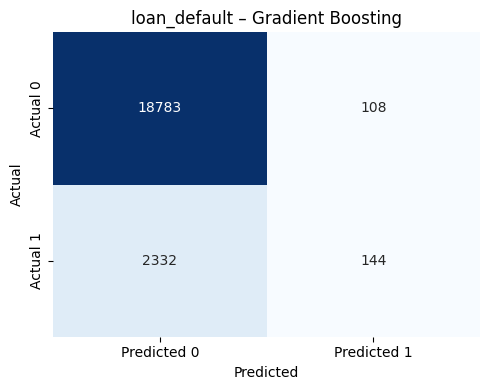

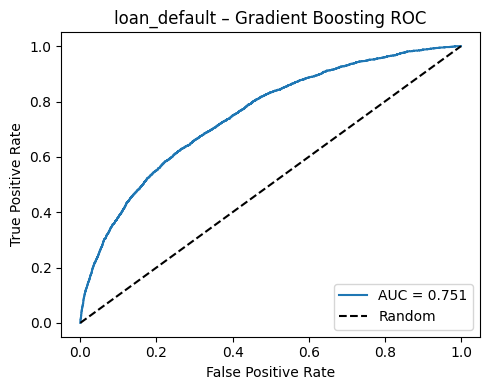


=== Plots for credit_risk – Gradient Boosting ===


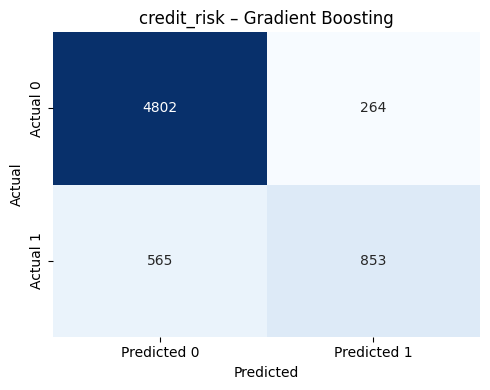

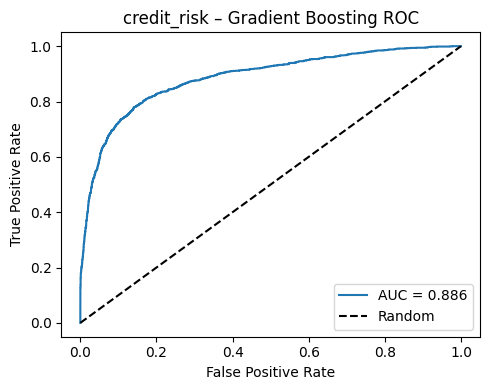

In [4]:
for name, cfg in datasets.items():
    print(f"\n=== Plots for {name} – Gradient Boosting ===")

    # unpack everything you saved earlier
    X_train, X_val, X_test, y_train, y_val, y_test = all_results[name]["splits"]
    X_train_scaled, X_val_scaled, X_test_scaled = all_results[name]["scaled"]

    # rebuild numeric-only views for this dataset
    X_test_num = X_test.select_dtypes(include=["number"])

    gb = all_results[name]["models"]["gradient_boosting"]

    plot_confusion_matrix(
        gb,
        X_test_num,
        y_test,
        title=f"{name} – Gradient Boosting"
    )
    plot_roc_curve(
        gb,
        X_test_num,
        y_test,
        title=f"{name} – Gradient Boosting ROC"
    )


Risk Band and Portfolio View

In [5]:
# Recover splits and feature columns
credit_cfg = datasets["credit_risk"]
(
    X_train_l,
    X_val_l,
    X_test_l,
    y_train_l,
    y_val_l,
    y_test_l,
) = all_results["credit_risk"]["splits"]

feature_cols = list(credit_gb.feature_names_in_)
X_test_l_num = X_test_l[feature_cols]

# Build portfolio using the model (credit_gb) and an exposure column from X
credit_portfolio = build_portfolio_df(
    X=X_test_l_num,
    y=y_test_l,
    model=credit_gb,
    exposure_col_name="loan_amnt",  # or whatever exposure column you want
    lgd=0.45,
)


In [6]:
#  Recover splits for loan_default
(
    X_train_ld,
    X_val_ld,
    X_test_ld,
    y_train_ld,
    y_val_ld,
    y_test_ld,
) = all_results["loan_default"]["splits"]

# Use the exact feature names seen at fit time
loan_feature_cols = list(loan_gb.feature_names_in_)

X_test_ld_num = X_test_ld[loan_feature_cols]

# Build portfolio using the model (loan_gb) and an exposure column in X
loan_portfolio = build_portfolio_df(
    X=X_test_ld_num,
    y=y_test_ld,
    model=loan_gb,
    exposure_col_name="loan_amount",  # or the appropriate exposure column name
    lgd=0.45,
)


In [7]:

loan_band_view = summarize_by_band(loan_portfolio)
credit_band_view = summarize_by_band(credit_portfolio)

print("Loan_default – risk bands")
display(loan_band_view)

print("Credit_risk – risk bands")
display(credit_band_view)

Loan_default – risk bands


,risk_band,n_loans,exposure_sum,default_rate,avg_pd,expected_loss_sum,exposure_share
0,Low,5437,590682187,0.027773,0.035501,9.585063e+06,0.216663
1,Medium,10926,1378797526,0.089511,0.089106,5.608201e+07,0.505744
2,High,5004,756796369,0.269185,0.261461,9.279604e+07,0.277593


Credit_risk – risk bands


,risk_band,n_loans,exposure_sum,default_rate,avg_pd,expected_loss_sum,exposure_share
0,Low,1843,16964800,0.030385,0.035454,2.701329e+05,0.272527
1,Medium,2421,20970875,0.076415,0.087391,7.936149e+05,0.336882
2,High,2220,24314300,0.530180,0.512548,5.939177e+06,0.390591


In [8]:

import joblib
from pathlib import Path

models_dir = ROOT / "models"
models_dir.mkdir(exist_ok=True)

# For the loan_default dataset
joblib.dump(log_reg, models_dir / "loan_log_reg.joblib")
joblib.dump(rf,      models_dir / "loan_rf.joblib")
joblib.dump(gb,      models_dir / "loan_gb.joblib")

# For the credit_risk dataset
joblib.dump(credit_log_reg, models_dir / "credit_log_reg.joblib")
joblib.dump(credit_rf,      models_dir / "credit_rf.joblib")
joblib.dump(credit_gb,      models_dir / "credit_gb.joblib")


# Base project directory
data_dir = ROOT / "data" / "outputs"
data_dir.mkdir(parents=True, exist_ok=True)

# Save band-level summaries
loan_band_view.to_csv(data_dir / "loan_risk_bands.csv", index=False)
credit_band_view.to_csv(data_dir / "credit_risk_bands.csv", index=False)

# (Optional) save full loan-level portfolios as well
loan_portfolio.to_csv(data_dir / "loan_portfolio_scored.csv", index=False)
credit_portfolio.to_csv(data_dir / "credit_portfolio_scored.csv", index=False)

